In [20]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K
import math


#import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.image as mpimg
from  matplotlib import pyplot
import cv2
import random
from PIL import Image
from sklearn.utils import class_weight
import numpy
import codecs
import xmltodict

import imgaug as ia
from imgaug import augmenters as iaa
import math



import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda,RepeatVector,Dot
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape,merge,Concatenate,Add,Dropout
import keras.backend as K
import math
from keras.activations import softmax,tanh
import tensorflow as tf
from keras.applications.vgg16 import VGG16


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D,Softmax
from keras.preprocessing import sequence

from tensorflow.python.client import device_lib
device_lib.list_local_devices()


def process_image_keypoints(img,bbox_coords):
    desired_size = 224

    old_size = img.shape

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    bbox_coordinates = []
    for a,b in bbox_coords:
        a = float(a)*ratio
        b = float(b)*ratio
        bbox_coordinates.append([a+left,b+top])
    return new_im,bbox_coordinates


def process_image_keypoints_nobox(img):
    desired_size = 224

    old_size = img.shape

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    return new_im,[left,top,ratio]


def attention_block(x,K,labels,w,h):
    H = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    H = BatchNormalization()(H)
    spatial_softmax = Lambda(lambda x:softmax(H,axis=3))(H)
    O = Conv2D(labels*K, kernel_size=(w, h), padding="same")(x)
    O = BatchNormalization()(O)
    rH = Lambda(lambda x:keras.backend.repeat_elements(x, rep=labels, axis=3))(spatial_softmax)
    o = Lambda(lambda x: tf.einsum('bijk,bijk->bk',x[0],x[1]))([O,rH])
    tempH = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    tempH = BatchNormalization()(tempH)
    gh = Lambda(lambda x: softmax(tanh(tf.einsum('bijk,bijk->bk',x[0],x[1])),axis=1))([tempH,spatial_softmax])
    rgh = Lambda(lambda x:keras.backend.repeat_elements(x, rep=labels, axis=1))(gh)
    of = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([rgh,o])
    new_shape = Reshape((labels,K))(of)
    out = Lambda(lambda x: keras.backend.sum(x,axis=2))(new_shape)
    out = BatchNormalization()(out)
    out = Dense(labels,activation='sigmoid')(out)
    #x = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    #inter = Lambda(lambda x: Flatten()(keras.backend.mean(x,axis=3)))(x)
    inter = Conv2D(128, kernel_size=(w, h), padding="same")(x)
    inter = MaxPooling2D(pool_size=(2, 2))(inter)
    inter = BatchNormalization()(inter)
    inter = Conv2D(128, kernel_size=(w, h), padding="same")(inter)
    inter = MaxPooling2D(pool_size=(2, 2))(inter)
    inter = BatchNormalization()(inter)
    print(inter.shape)
    inter = Conv2D(1, kernel_size=(w, h), padding="same")(inter)
    inter = Flatten()(inter)
    weight = Dense(labels,activation='tanh')(inter)
    return out,weight

K = 10
labels = 1
w,h = 3,3

cnn_base = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    if layer.name=='block5_conv3':
        break
    layer.trainable = False


x = cnn_base.get_layer('block3_conv3').output
final1,weight1 = attention_block(x,K,labels,w,h)
#final1 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([final1,weight1])

x = cnn_base.get_layer('block4_conv3').output
final2,weight2 = attention_block(x,K,labels,w,h)

#final2 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([final2,weight2])

x = cnn_base.get_layer('block5_pool').output
inter = Lambda(lambda x: Flatten()(x[:,:,:,0]))(x)
weight3 = Dense(1,activation='tanh')(inter)

x = Flatten()(x)
x = Dense(64,activation='tanh')(x)
x = BatchNormalization()(x)
x = Dense(64,activation='tanh')(x)
x = BatchNormalization()(x)
x = Dense(1,activation='sigmoid')(x)


weight_concat = Concatenate()([weight1,weight2,weight3])
weight_concat = Reshape((labels,3))(weight_concat)
weight_concat = Softmax(axis=2)(weight_concat)

final = Concatenate()([final1,final2,x])
final = Reshape((labels,3))(final)


sum_final = Lambda(lambda x: tf.einsum('bij,bij->bij',x[0],x[1]))([weight_concat,final])
sum_final = Lambda(lambda x: keras.backend.sum(x,axis=2))(sum_final)
sum_final = Dense(labels,activation='sigmoid')(sum_final)

model = Model(inputs=cnn_base.input, outputs=sum_final)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
print(model.summary())
with open('somite-classification10.hd5','rb') as f:
    model_weights = pickle.load(f)
    print("loaded model")
model.set_weights(model_weights)

(?, 14, 14, 128)
(?, 7, 7, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_____________________________________________________________________________

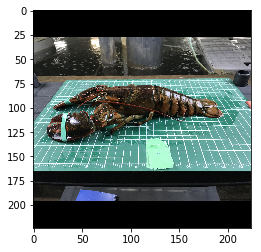

In [33]:
bgr_img = cv2.imread("/tf/data/5_3.jpg.JPG")
img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

img_temp,corr = process_image_keypoints_nobox(img)
img_temp = (img_temp[:,:,:] / 255.0).astype(np.float64)
plt.imshow(img_temp)

In [34]:
pred = model.predict(x=np.expand_dims(img_temp,0))[0][0]>0.5
pred = int(pred)
if pred==0:
    print("Non-aggressive")
else:
    print("Aggressive")

Non-aggressive
